In [1]:
#auotoreload
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
from PIL import Image

from constants import UNCONDITIONAL_DIFFUSION_MODEL_REPO, DIFFUSION_MODEL_REPO, TMP_FOLDER_PATH, MODEL_FOLDER_PATH, IMAGE_FOLDER_PATH, CUDA_DEVICE, TEXT_TO_IMAGE_PROMPTS
from utils import image_grid

__This notebook is based on huggingface diffusers task overview https://huggingface.co/docs/diffusers/using-diffusers/pipeline_overview__

## 1.1 Unconditional Generation

In [3]:
from diffusers import DiffusionPipeline

In [4]:
pipe = DiffusionPipeline.from_pretrained(UNCONDITIONAL_DIFFUSION_MODEL_REPO, cache_dir=MODEL_FOLDER_PATH).to(CUDA_DEVICE)
pipe

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.24.0.dev0",
  "_name_or_path": "google/ddpm-church-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

  0%|          | 0/1000 [00:00<?, ?it/s]

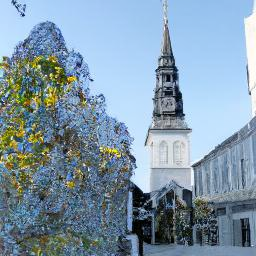

In [5]:
torch.manual_seed(1)
image = pipe().images[0]
image.save(IMAGE_FOLDER_PATH/'1.unconditional_generation.png')
image

__Note: if you have limited GPU memory, please restart the kernel and rerun import cell before proceeding to the next subsection__

## 1.2 Text to Image 

In [6]:
from diffusers import StableDiffusionPipeline

In [7]:
pipe = StableDiffusionPipeline.from_pretrained(DIFFUSION_MODEL_REPO, cache_dir=MODEL_FOLDER_PATH).to(CUDA_DEVICE)
pipe

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.24.0.dev0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

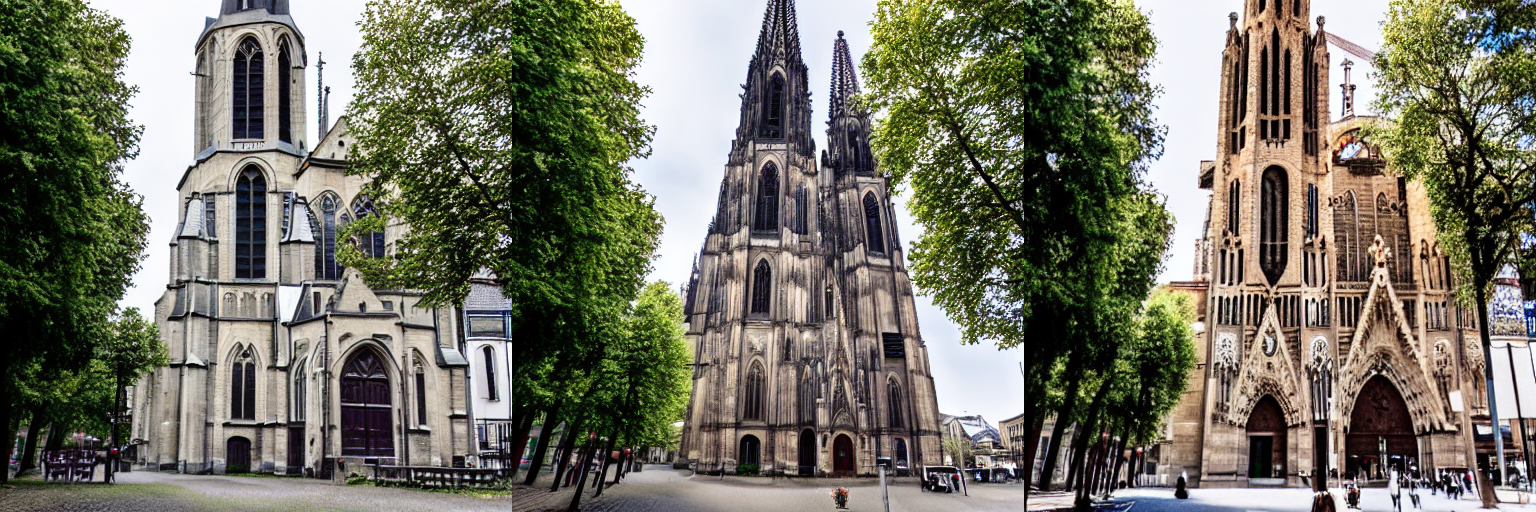

In [8]:

text_to_images = []
for idx, prompt in enumerate(TEXT_TO_IMAGE_PROMPTS):
    torch.manual_seed(0)
    image = pipe(prompt=prompt).images[0]
    text_to_images.append(image)
    image.save(IMAGE_FOLDER_PATH/f'2.{prompt.lower().replace(" ", "_")}.png')    
# faster alternative: images = pipe(prompt=prompts).images    
image_grid(text_to_images, rows=1, cols=3)

# 1.3 image to image

In [9]:
from diffusers import StableDiffusionImg2ImgPipeline

In [10]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(DIFFUSION_MODEL_REPO, cache_dir=MODEL_FOLDER_PATH).to(CUDA_DEVICE)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

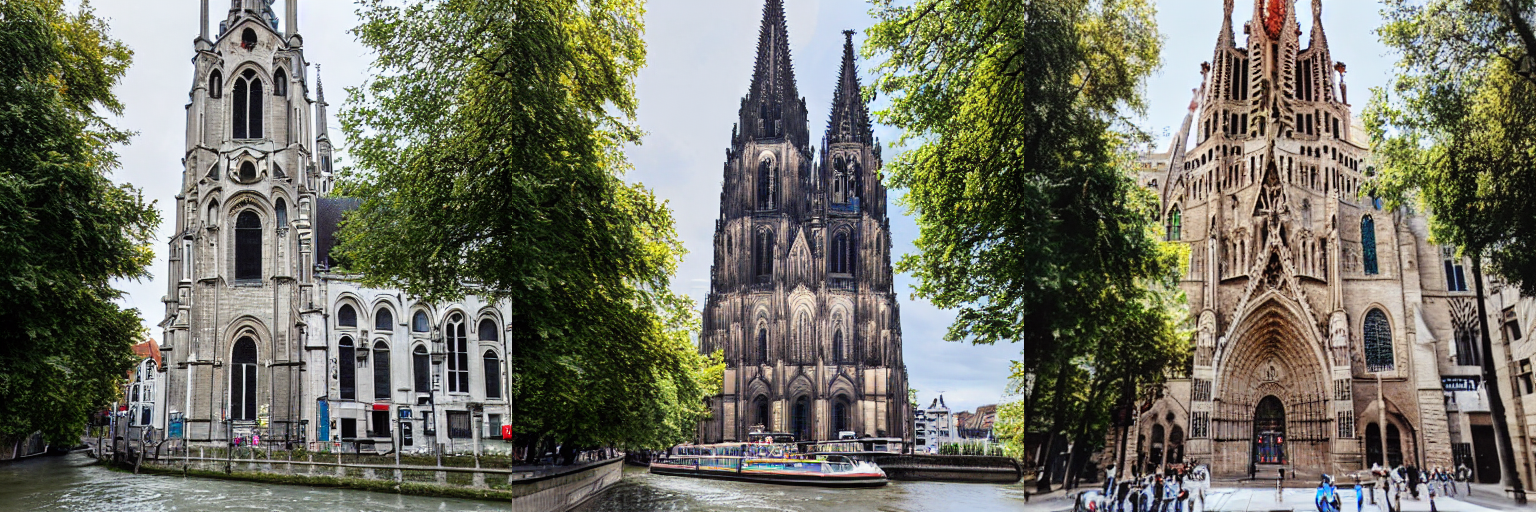

In [11]:
prompt_suffix = " next to a canal"
image_to_images = []
for idx, prompt in enumerate(TEXT_TO_IMAGE_PROMPTS):
    torch.manual_seed(0)
    image = pipe(prompt=prompt + prompt_suffix, num_images_per_prompt=1, image=text_to_images[idx], strength=0.7, num_inference_steps=50).images[0]
    image_to_images.append(image)
image_grid(image_to_images, rows=1, cols=3)

## 1.3 inpainting

In [12]:
from diffusers import StableDiffusionInpaintPipeline

In [13]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(DIFFUSION_MODEL_REPO, cache_dir=MODEL_FOLDER_PATH).to(CUDA_DEVICE)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [14]:
init_image = image_to_images[2]
# generate black image
mask_image = Image.new("RGB", init_image.size, (0, 0, 0))
# set height from 460 to 512 white
mask_image.paste((255, 255, 255), box=(0, 480, 512, 512))

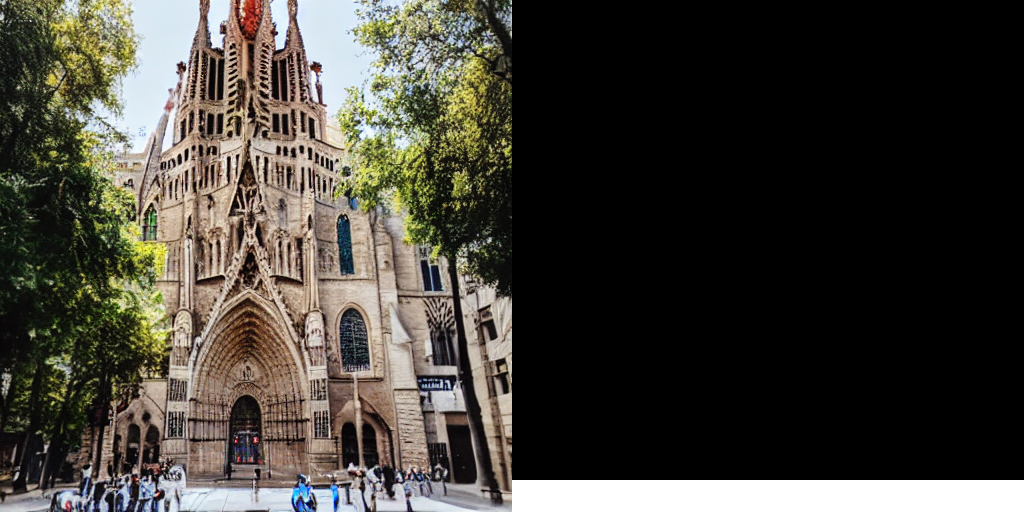

In [15]:
image_grid([init_image, mask_image], rows=1, cols=2)

  0%|          | 0/50 [00:00<?, ?it/s]

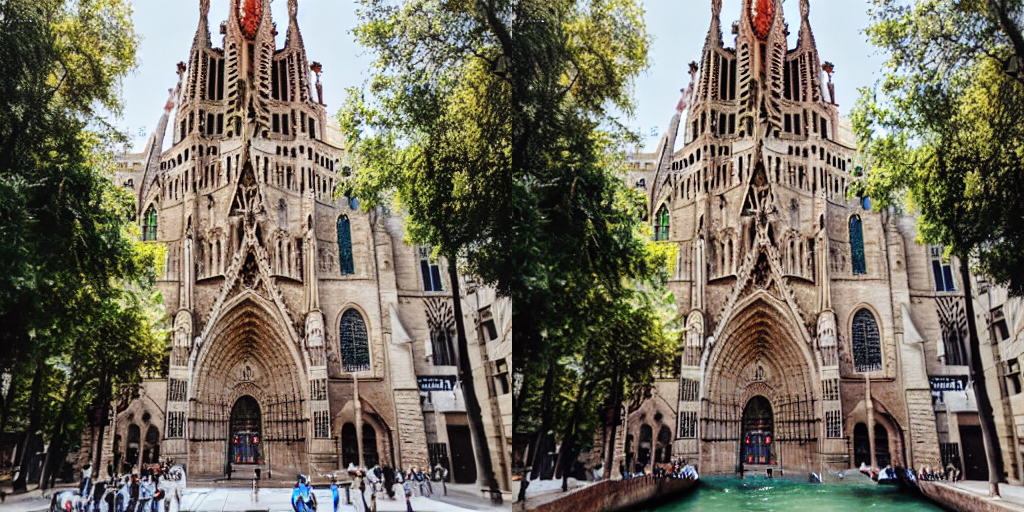

In [16]:
torch.manual_seed(8)
prompt = TEXT_TO_IMAGE_PROMPTS[2] + prompt_suffix
inpainting_image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
image_grid([init_image, inpainting_image], rows=1, cols=2)